In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
warnings.filterwarnings(action='ignore')


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils.preprocess_utils import *
from utils.train_utils import *
from models.model_trend.trend_lstm import LSTMModel_trend

In [2]:
### morning data
with open('../data/preprocess/e_data_list.pkl', 'rb') as f:
#with open('data/preprocess/l_data_list.pkl', 'rb') as f:
#with open('data/preprocess/e_data_list.pkl', 'rb') as f:
#with open('data/preprocess/full_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)
data_list = append_cycle_size(data_list)
train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

In [3]:
# Load model
model_trend = LSTMModel_trend(input_size = 10, hidden_size = 32, no_time_size =4).to(device)

In [4]:
train_notime.shape

torch.Size([11247, 4])

In [5]:
optimizer = torch.optim.Adam(model_trend.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

# Train model
num_epochs  = 500
hist = np.zeros(num_epochs)

train_error = []
valid_error = []

hist = {'best_val_error': 100,
        'best_val_epoch': 0}


for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()  
    # Forward pass
    train_trend_pred = model_trend(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,0]) ### trend
    train_error.append(loss)

    valid_trend_pred = model_trend(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,0]).cpu()) ### trend
    valid_error.append(valid_mse)

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t

    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

10 Epochs train MSE: 0.07886 // valid MSE: 0.05841
20 Epochs train MSE: 0.04356 // valid MSE: 0.02693
30 Epochs train MSE: 0.02033 // valid MSE: 0.01332
40 Epochs train MSE: 0.01381 // valid MSE: 0.01327
50 Epochs train MSE: 0.01138 // valid MSE: 0.01555
60 Epochs train MSE: 0.01046 // valid MSE: 0.01291
70 Epochs train MSE: 0.00977 // valid MSE: 0.01290
80 Epochs train MSE: 0.00929 // valid MSE: 0.01321
90 Epochs train MSE: 0.00892 // valid MSE: 0.01329
100 Epochs train MSE: 0.00858 // valid MSE: 0.01311
110 Epochs train MSE: 0.00823 // valid MSE: 0.01279
120 Epochs train MSE: 0.00786 // valid MSE: 0.01236
130 Epochs train MSE: 0.00746 // valid MSE: 0.01205
140 Epochs train MSE: 0.00704 // valid MSE: 0.01184
150 Epochs train MSE: 0.00662 // valid MSE: 0.01177
160 Epochs train MSE: 0.00623 // valid MSE: 0.01173
170 Epochs train MSE: 0.00590 // valid MSE: 0.01167
180 Epochs train MSE: 0.00562 // valid MSE: 0.01171
190 Epochs train MSE: 0.00538 // valid MSE: 0.01189
200 Epochs train MSE:

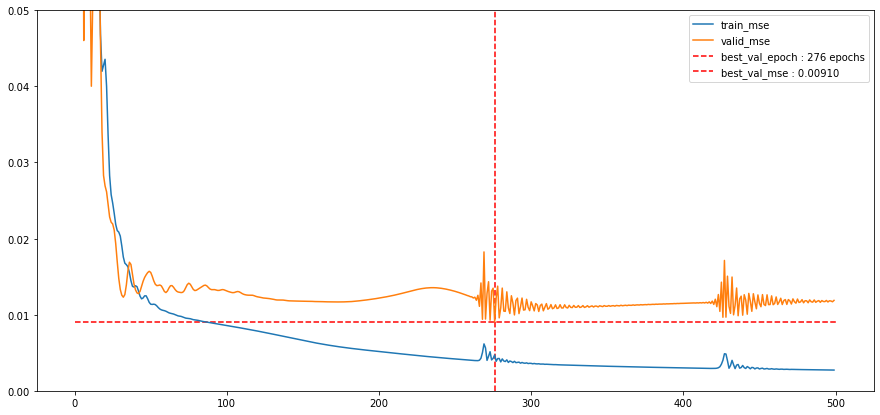

In [6]:
# no time time 곱하기
# cycle size 더하기

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 0.1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.05)
plt.show()

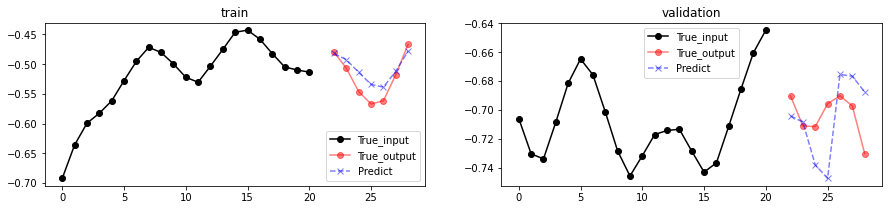

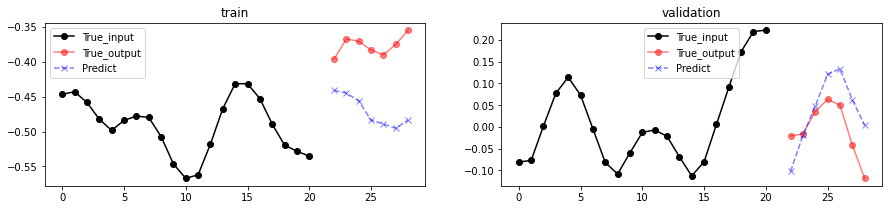

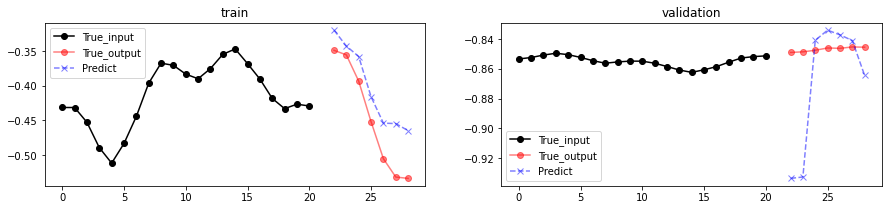

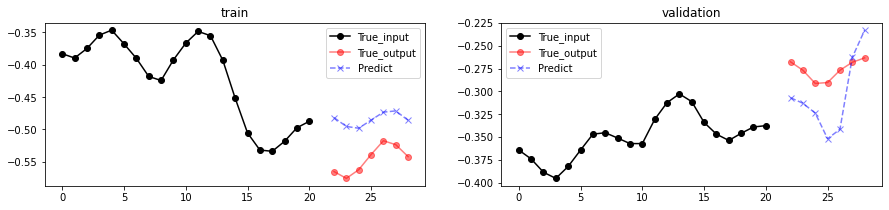

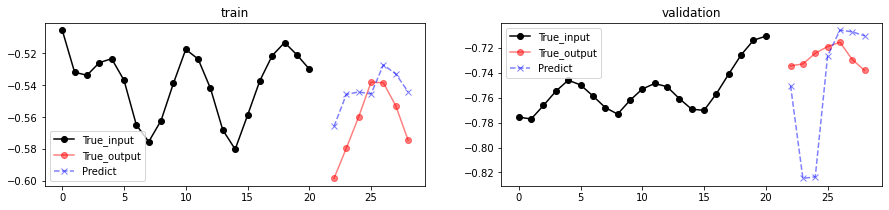

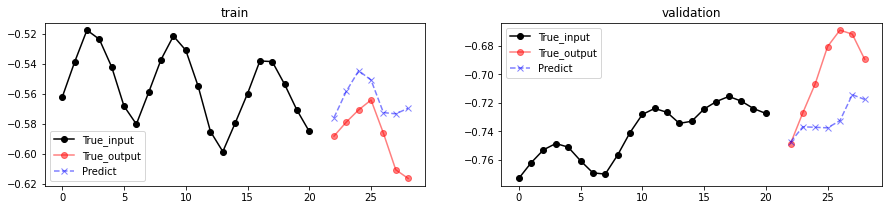

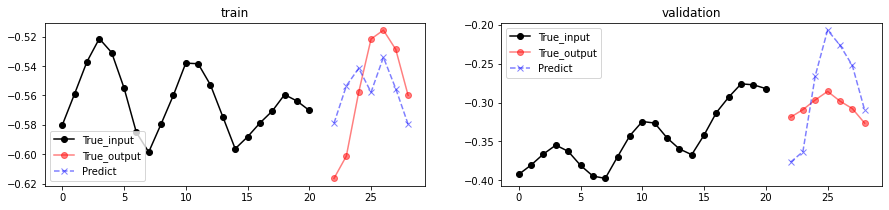

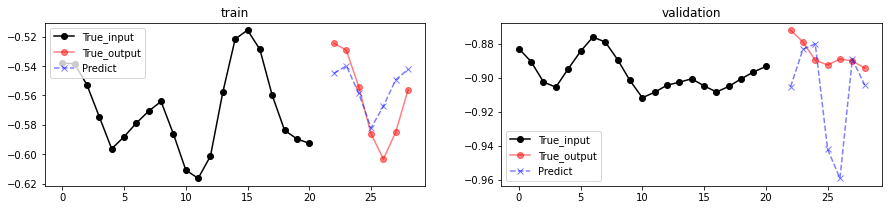

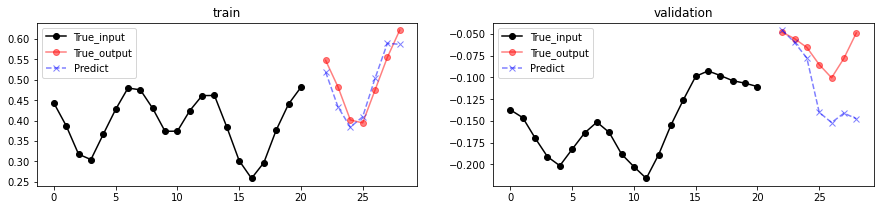

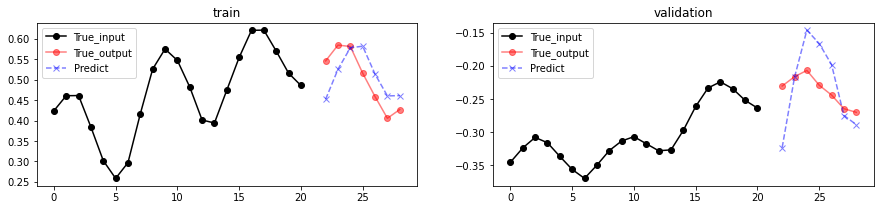

In [7]:
train_x_np, train_y_np, train_pred_np,\
valid_time_x_np, valid_y_np, valid_pred_np= tensor2numpy([train_time[:,:,-2], train_y[:,:,0], train_trend_pred,
                                                        valid_time[:,:,-2], valid_y[:,:,0], valid_trend_pred])

plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

trend_result_list = [train_x_np, train_y_np, train_pred_np,\
    valid_time_x_np, valid_y_np, valid_pred_np]

### morning result
path = '../data/train_results/evening_results/'
with open(path + 'e_trend_results_list.pkl', 'wb') as f:
    pickle.dump(trend_result_list, f)